In [1]:
import scanpy as sc
import squidpy as sq
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from scipy.stats import chi2_contingency

from bin import utils

In [2]:
fdata = sc.read_h5ad('./RNA/Multitime.clustered.h5')
gdata = sc.read_h5ad('./RNA/Multitime.filtered.guide.bin100.h5')

In [3]:
def align_rna_guide_data(fdata, gdata):
    gdata.obs.marker = gdata.obs.marker.map({
        'B926-1': '2-1',
        'B926-2': '2-2',
        'B924-1': '1-1',
        'B924-2': '1-2',
        'B922-1': '3-1',
        'B922-2': '3-2'
    })
    fdata.obs['coord_x'] = fdata.obsm['spatial'][:, 0] // 100 * 100
    fdata.obs['coord_y'] = fdata.obsm['spatial'][:, 1] // 100 * 100

    gdata.obs['coord_x'] = gdata.obsm['spatial'][:, 0] // 100 * 100
    gdata.obs['coord_y'] = gdata.obsm['spatial'][:, 1] // 100 * 100

    gdata.obs_names = [str(marker) + '_' + str(x) + '_' + str(y) for marker, x, y in zip(gdata.obs['marker'], gdata.obs['coord_x'], gdata.obs['coord_y'])]
    fdata.obs_names = [str(marker) + '_' + str(x) + '_' + str(y) for marker, x, y in zip(fdata.obs['marker'], fdata.obs['coord_x'], fdata.obs['coord_y'])]

    common_bins = np.intersect1d(fdata.obs_names, gdata.obs_names)
    fdata = fdata[common_bins].copy()
    gdata = gdata[common_bins].copy()

    gdata.obs["cluster"] = fdata.obs["cluster_cellcharter_givenk"].tolist()
    return fdata, gdata
fdata, gdata = align_rna_guide_data(fdata, gdata)

In [4]:
gdata = utils.combine_guide_replicates(gdata)

/home/wpy/stereoseq/20240502-SPACseq/bin/utils.py:88: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()


In [22]:
cdf = pd.concat([pd.DataFrame(gdata.X, index=gdata.obs_names, columns=gdata.var_names), gdata.obs[['marker', 'cluster']]], axis=1)
# cdf = pd.concat([pd.DataFrame(gdata.X, index=gdata.obs_names, columns=gdata.var_names), gdata.obs[['cluster']]], axis=1)

In [23]:
mdf = cdf.groupby(['marker', 'cluster']).sum().melt(ignore_index=False).reset_index()
# mdf = cdf.groupby(['cluster']).sum().melt(ignore_index=False).reset_index()

/tmp/ipykernel_60226/356721922.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mdf = cdf.groupby(['marker', 'cluster']).sum().melt(ignore_index=False).reset_index()


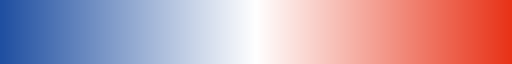

In [7]:
from types import new_class
from matplotlib.colors import LinearSegmentedColormap

colors = ['#1f4fa1', '#ffffff', '#e83217']
n_bins = 256
new_cmap = LinearSegmentedColormap.from_list('custom_diverging', colors, N=n_bins)
new_cmap

In [ ]:
plt.figure(figsize=(3, 3))
plot_df = mdf.groupby('cluster')['value'].sum()
plt.pie(plot_df, labels=[f'c{i}' for i in range(1,13)], autopct=lambda pct: f'{pct:.1f}%', 
        colors=new_cmap(np.linspace(0, 1, len(plot_df))))

plt.rcParams['pdf.fonttype'] = 42
plt.savefig('../20240822-Pipeline/supplementary_images/cluster_specific_distribution_pie.pdf', bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(figsize=(3, 3))
plot_df = mdf[mdf.variable == 'sgnon-targeting'].groupby('cluster')['value'].sum()
plt.pie(plot_df, labels=[f'c{i}' for i in range(1,13)], autopct=lambda pct: f'{pct:.1f}%', 
        colors=new_cmap(np.linspace(0, 1, len(plot_df))))

plt.rcParams['pdf.fonttype'] = 42
plt.savefig('../20240822-Pipeline/supplementary_images/cluster_specific_distribution_pie_sgnon-targeting.pdf', bbox_inches='tight')
plt.show()

In [ ]:
_, axs = plt.subplots(2, 3, figsize=(12, 8))
for ax, marker in zip(axs.flatten(), ['2-1', '2-2', '1-1', '1-2', '3-1', '3-2']):
    MARKER = marker
    plot_df = mdf[mdf.marker == MARKER].groupby('cluster')['value'].sum()

    ax.pie(plot_df, labels=plot_df.index, autopct='%1.1f%%', colors=sns.color_palette('tab20c'))
    ax.set_title(MARKER)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')

# Chi Square

In [10]:
mdf.marker = 'all'

In [24]:
MARKER = '2-1'
p_dict = {}

for cluster in mdf.cluster.unique():
    p_dict[cluster] = []
    for guide in mdf.variable.unique():
        if guide == 'sgnon-targeting': continue
        int_df = mdf[(mdf.marker == MARKER) & (mdf.cluster == cluster) & np.isin(mdf.variable, [guide, 'sgnon-targeting'])][['variable', 'value']].set_index('variable')
        res_df = mdf[(mdf.marker != MARKER) & (mdf.cluster != cluster) & np.isin(mdf.variable, [guide, 'sgnon-targeting'])].set_index('cluster')[['variable', 'value']].groupby('variable').sum()
        chi_df = pd.concat([int_df, res_df], axis=1)
        chi_df.columns = ['cluster_' + str(cluster), 'rest']
        pval = chi2_contingency(chi_df)[1]
        p_dict[cluster].append(pval)
chi_df = pd.DataFrame(p_dict, index=gdata.var_names[:-1]).T

In [9]:
l2fc_dict = {}

pdf = mdf.set_index(['cluster', 'variable'])['value'].unstack()
pdf = pdf.div(pdf.sum(axis=0), axis=1)
pdf = pdf.div(pdf['sgnon-targeting'], axis=0).loc[:, pdf.columns != 'sgnon-targeting']

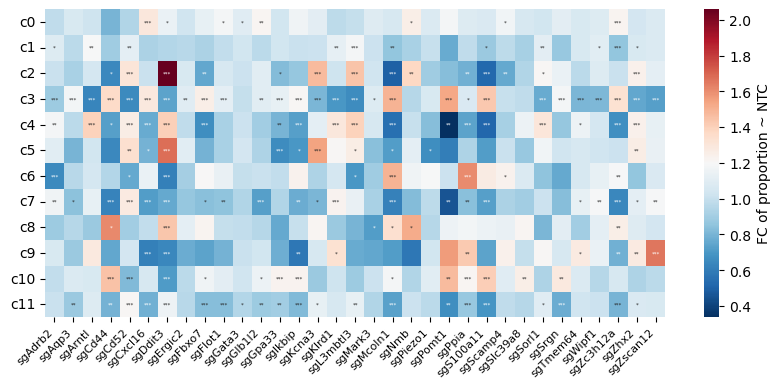

In [10]:
annot_df = chi_df.map(lambda x: '***' if x < 0.001 else ('**' if x < 0.01 else ('*' if x < 0.05 else '')))
plt.figure(figsize=(10, 4))
heatmap = sns.heatmap(pdf, annot=annot_df, fmt='s', cmap='RdBu_r', annot_kws={'size': 4})

colorbar = heatmap.collections[0].colorbar
colorbar.set_label('FC of proportion ~ NTC')
plt.ylabel('')
plt.yticks(np.arange(12) + 0.5, ['c' + str(i) for i in range(12)], rotation=0)
plt.xticks(rotation=45, ha='right', fontsize=8)
# plt.xlabel('Guide')
plt.xlabel('')
# plt.title('Cluster specific proportion with Chi2 contingency')
plt.show()

                   p-value        FC  rank       padj  Label
sgZc3h12a c3  2.188771e-67  0.407689     0  30.000000  False
sgDdit3 c2    5.341391e-43  1.041957     1  30.000000   True
sgMcoln1 c3   7.032625e-39  0.584611     2  30.000000  False
sgCd52 c3     1.052673e-35 -0.623339     3  30.000000   True
sgZc3h12a c7  1.589607e-31 -0.644896     4  28.899985   True
...                    ...       ...   ...        ...    ...
sgSlc39a8 c9  1.000000e+00 -0.013851   391  -0.000000  False
sgIkbip c8    1.000000e+00  0.002308   392  -0.000000  False
sgPomt1 c6    1.000000e+00  0.021664   393  -0.000000  False
sgNmb c4      1.000000e+00  0.003896   394  -0.000000  False
sgFlot1 c8    1.000000e+00 -0.006405   395  -0.000000  False

[396 rows x 5 columns]


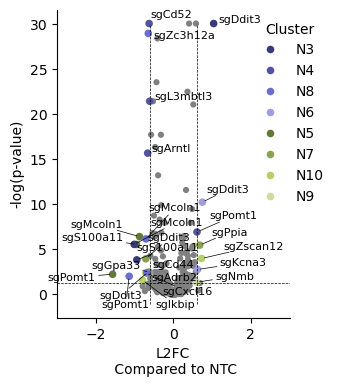

In [21]:
from adjustText import adjust_text
from igraph import palettes

plot_df = pd.DataFrame({
    'p-value':  chi_df.melt().value.tolist(),
    'FC': list(np.log2(pdf.melt().value + 1e-9))
}, index=[str(a) + ' c' + str(b) for a, b in zip(chi_df.melt().variable, chi_df.melt(ignore_index=False).index)])

plot_df = plot_df[plot_df.FC > np.log2(1e-6)]

plot_df.sort_values(by='p-value', ascending=True, inplace=True)
plot_df['rank'] = np.arange(len(plot_df))
plot_df['padj'] = plot_df['p-value'] * len(plot_df) / (plot_df['rank'] + 1)
plot_df['padj'] = -np.log10(plot_df['padj'].clip(upper=1))
plot_df['padj'] = plot_df['padj'].clip(upper=30)

plot_df['Label'] = (plot_df['padj'] > -np.log10(0.05)) & (np.abs(plot_df['FC']) > 0.6)
print(plot_df)

# Create scatter plot
plt.figure(figsize=(3, 4))
scatter = sns.scatterplot(data=plot_df[~plot_df.Label], x='FC', y='padj',
                          color='grey', legend=False, s=20, edgecolor='none')
plot_df['Cluster'] = np.int16(plot_df.index.str.split(' c').str[1]) + 1
plot_df['Cluster'] = plot_df['Cluster'].map(lambda x: 'N' + str(x))
plot_df['Guide'] = plot_df.index.str.split(' c').str[0]
sns.scatterplot(data=plot_df[plot_df.Label], x='FC', y='padj', hue='Cluster',
                legend=True, s=30, ax=scatter, edgecolor='none', palette='tab20b')


# Add labels for points where 'Label' is True
texts = []
for i, point in plot_df[plot_df['Label']].iterrows():
    texts.append(plt.text(point['FC'], point['padj'], plot_df['Guide'][i], size=8))

scatter.hlines(y=-np.log10(0.05), xmin=-3, xmax=3, color='black', linestyles='--', linewidth=0.5)
scatter.vlines(x=-0.6, ymin=-1, ymax=30, color='black', linestyles='--', linewidth=0.5)
scatter.vlines(x=0.6, ymin=-1, ymax=30, color='black', linestyles='--', linewidth=0.5)

# Adjust text to prevent overlap
adjust_text(texts, expand_axes=True, arrowprops=dict(arrowstyle='-', color='black', lw=0.5))

# Set x and y limits and labels
plt.xlim((-3, 3))
plt.xlabel('L2FC\n Compared to NTC')
plt.ylabel('-log(p-value)')
# plt.title('Volcano Plot of guide cnt in cluster')

plt.legend(title='Cluster', loc='upper right', frameon=False, bbox_to_anchor=(1.2, 1))

sns.despine()
plt.rcParams['pdf.fonttype'] = 42
plt.savefig('../20240822-Pipeline/supplementary_images/cluster_specific_distribution_volcano.pdf', bbox_inches='tight')
plt.show()


In [13]:
gdata.obs['cluster'] = fdata.obs['cluster_cellcharter_givenk']
mdata = gdata[gdata.obs.marker == '2-1']
c_df = pd.concat([pd.DataFrame(mdata.X, columns=mdata.var_names, index=mdata.obs_names), mdata.obs["cluster"]], axis=1)
c_df = c_df.groupby('cluster').sum()
c_df = c_df.div(c_df.sum(axis=0)) * c_df.loc[:, 'sgnon-targeting'].sum()

from scipy.stats import chi2_contingency
from tqdm import tqdm
ait_dist = {}
for guide in tqdm(c_df.columns):
    if c_df.loc[:, guide].sum() < 10: continue
    observed = np.array([c_df.sum(axis=1).tolist(), c_df[guide].tolist()]).T
    chi_p[guide] = chi2_contingency(observed)[1]

/tmp/ipykernel_38330/2831546009.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  c_df = c_df.groupby('cluster').sum()
100%|██████████| 34/34 [00:00<00:00, 1162.25it/s]


# CLR

In [20]:
# mdata.obs['cluster'] = fdata.obs.cluster_cellcharter_givenk.tolist()
from scipy.spatial.distance import euclidean

mdata = gdata[gdata.obs.marker == '2-2']
# mdata = gdata
c_df = pd.concat([pd.DataFrame(mdata.X, columns=mdata.var_names, index=mdata.obs_names), mdata.obs.cluster], axis=1)
c_df = c_df.groupby(['cluster']).sum().unstack().unstack()

g_df = c_df.apply(lambda x: 10 ** (np.log10(x + 1) - (np.log10(x + 1).sum() / 12)), axis=1)
dist = g_df.apply(lambda x: euclidean(x, g_df.loc['sgnon-targeting']), axis=1).values
dist

array([2.6850589 , 0.64129483, 3.8058898 , 3.11641197, 2.39359262,
       0.90746242, 1.07736315, 2.66134375, 2.44468674, 1.49674259,
       1.45426849, 2.70812047, 1.67983412, 1.88833241, 2.66471944,
       2.4149491 , 2.89026032, 2.06846456, 2.17712896, 1.78878261,
       1.74208598, 3.20255402, 2.4264507 , 1.7543526 , 1.9998057 ,
       2.90609286, 1.65421423, 2.69445033, 1.94686738, 2.41946952,
       1.40887371, 1.98189174, 0.80726231, 0.        ])

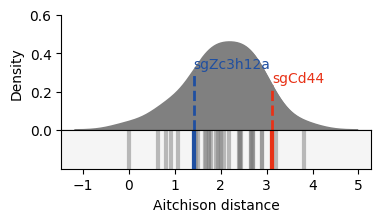

In [22]:
from statsmodels.nonparametric.kde import KDEUnivariate

# 初始化KDE估计器
perm_df = pd.DataFrame(dist, index=g_df.index)
perm_df['Aitchison distance'] = perm_df[0]
kde = KDEUnivariate(perm_df['Aitchison distance'])

# 拟合数据
kde.fit()

# 绘制KDE曲线
fig, ax = plt.subplots(2, 1, figsize=(4, 2), sharex=False, height_ratios=[3, 1], gridspec_kw={'hspace': 0})
# ax[0].set_xlim(0, 7e-10)
ax[0].set_ylim(0, 0.6)

for gene, color in zip(['sgZc3h12a', 'sgCd44'], new_cmap(np.linspace(0, 1, 2))):
    if gene in perm_df.index:
        pos = perm_df.loc[gene, 'Aitchison distance']
        ax[0].vlines(x=pos, ymin=0, ymax=kde.density[np.abs(kde.support - pos).argmin()], color=color, linestyles='--',
                   alpha=1, linewidth=2)
        ax[0].text(pos, kde.density[np.abs(kde.support - pos).argmin()], gene, color=color, rotation=0, ha='left', va='bottom')

ax[0].fill_between(kde.support, kde.density, alpha=1, color='gray')
ax[0].plot(kde.support, kde.density, color='gray')

lim = ax[0].get_xlim()

ax[0].set_xlabel('')
ax[0].set_xticks([])
ax[0].set_ylabel('Density')
sns.despine(ax=ax[0])

for row in perm_df.iterrows():
    # print(row)
    ax[1].vlines(x=row[1], ymin=0, ymax=1, color='gray', linestyles='-',
               alpha=0.3, linewidth=3)
for gene, color in zip(['sgZc3h12a', 'sgCd44'], new_cmap(np.linspace(0, 1, 2))):
    if gene in perm_df.index:
        pos = perm_df.loc[gene, 'Aitchison distance']
        ax[1].vlines(x=pos, ymin=0, ymax=1, color=color, linestyles='-',
                   alpha=1, linewidth=3)

ax[1].set_facecolor('whitesmoke')
ax[1].set_ylim(0, 1)
ax[1].set_xlim(lim)
ax[1].set_xlabel('Aitchison distance')
ax[1].set_ylabel('')
ax[1].set_yticks([])

plt.rcParams['pdf.fonttype'] = 42
plt.savefig('../20240822-Pipeline/supplementary_images/aitchison_distance_kde.pdf',
            bbox_inches='tight', format='pdf')
plt.show()

# Chi Plotting

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


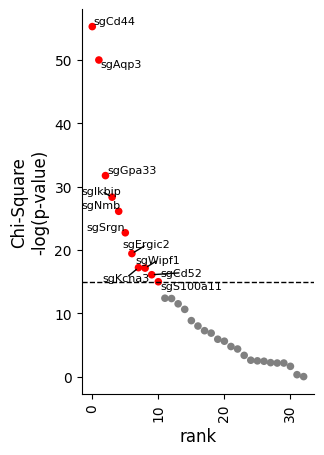

In [14]:
chi_df = pd.DataFrame(chi_p.values(), index=chi_p.keys())
chi_df = chi_df.loc[chi_df.index != 'sgPomt1', :]
# p_df = p_df.loc[guide_data.var_names[guide_data.X.sum(axis=0) > 0], :]
chi_df.sort_values(by=0, ascending=True, inplace=True)
chi_df['chi_p'] = -np.log10(chi_df[0])
chi_df.dropna(inplace=True)
chi_df['rank'] = np.arange(len(chi_df))
chi_df['sig'] = chi_df['rank'].map(lambda x: 'yes' if x <= 10 else 'no')

plt.figure(figsize=(3, 5))
sns.scatterplot(x='rank', y='chi_p', data=chi_df, color='black', s=30, hue='sig', palette=['red', 'gray'], legend=False, edgecolor='none')
plt.axhline(y=chi_df['chi_p'].iloc[10], color='black', linewidth=1, linestyle='--', alpha=1)
# plt.title('PERMANOVA between clusters-Count')
texts = []
cnt = 0
for i, row in chi_df.iterrows():
    if row['sig'] == 'yes':
        texts.append(plt.text(row['rank'], row['chi_p'], i, fontsize=8, alpha=1, ha='center', va='top', rotation=0))
        # plt.vlines(x=row['rank'], ymin=row['chi_p'] + cnt * 0.04, ymax=row['chi_p'], color='black', linewidth=0.5, linestyle='-', alpha=1)
        cnt += 1
import adjustText as aT
aT.adjust_text(texts=texts, expand_points=(0, 0), expand_text=(0, 0), ax=plt.gca(), arrowprops=dict(arrowstyle='-', color='black', lw=1))
plt.xlabel('rank', fontsize=12)
plt.xticks(rotation=90)
plt.ylabel('Chi-Square\n-log(p-value)', fontsize=12)
sns.despine()

# plt.ylim(-0.2, 1.2)

plt.rcParams['pdf.fonttype'] = 42
plt.savefig('../20240822-Pipeline/supplementary_images/chisquare.pdf', bbox_inches='tight', format='pdf')
plt.show()


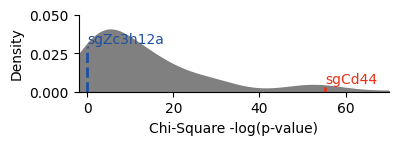

In [41]:
from statsmodels.nonparametric.kde import KDEUnivariate

# 初始化KDE估计器
kde = KDEUnivariate(chi_df['chi_p'])

# 拟合数据
kde.fit()

# 绘制KDE曲线
plt.figure(figsize=(4, 1))
plt.xlim(-2, 70)
plt.ylim(0, 0.05)

for gene, color in zip(['sgZc3h12a', 'sgCd44'], new_cmap(np.linspace(0, 1, 2))):
    if gene in chi_df.index:
        pos = chi_df.loc[gene, 'chi_p']
        plt.vlines(x=pos, ymin=0, ymax=kde.density[np.abs(kde.support - pos).argmin()], color=color, linestyles='--',
                   alpha=1, linewidth=2)
        plt.text(pos, kde.density[np.abs(kde.support - pos).argmin()], gene, color=color, rotation=0, ha='left', va='bottom')

plt.fill_between(kde.support, kde.density, alpha=1, color='gray')
plt.plot(kde.support, kde.density, color='gray')

plt.xlabel('Chi-Square -log(p-value)')
plt.ylabel('Density') 
sns.despine()

plt.rcParams['pdf.fonttype'] = 42
plt.savefig('../20240822-Pipeline/supplementary_images/chisquare_kde.pdf',
            bbox_inches='tight', format='pdf')
plt.show()


In [8]:
mdata = gdata[gdata.obs.marker == '2-1']
c_df = pd.concat([pd.DataFrame(mdata.X, columns=mdata.var_names, index=mdata.obs_names), mdata.obs.cluster], axis=1)

In [12]:
import warnings
from skbio.stats.distance import permanova, DistanceMatrix
from scipy.spatial.distance import pdist, squareform
from tqdm import tqdm
warnings.filterwarnings('ignore')

cd44_p_value = {}
zc3h12a_p_value = {}
plot_df = pd.DataFrame()
for i in range(5):
    for guide in tqdm(gdata.var_names):
        if guide != "sgCd44" and guide != "sgZc3h12a": continue
        for perm_times in [100, 200, 500, 1000]:
            g_df = c_df[[guide, "sgnon-targeting", "cluster"]]

            masks = {c: (g_df.cluster == c) for c in g_df.cluster.unique()}
            df = pd.DataFrame(columns=range(10))

            guide_cnts = np.array(pd.concat([df, g_df.groupby(['cluster', guide]).count().unstack()['sgnon-targeting']], axis=0).fillna(0))
            ntc_cnts = np.array(pd.concat([df, g_df.groupby(['cluster', 'sgnon-targeting']).count().unstack()[guide]], axis=0).fillna(0))
            data = np.vstack([guide_cnts, ntc_cnts])
            sample_ids = np.array([[name + str(c) for c in g_df.cluster.unique()] for name in ['guide_', 'control_']]).flatten()

            dist_matrix = squareform(pdist(data, metric='braycurtis'))
            metadata = pd.DataFrame({
                'group': ['A'] * 12 + ['B'] * 12
            }, index=sample_ids)
            dm = DistanceMatrix(dist_matrix, ids=sample_ids)

            results = permanova(dm, metadata, column='group', permutations=perm_times)
            #print(guide, results['p-value'])
            if guide == 'sgCd44':
                cd44_p_value[perm_times] = results['p-value']
            else:
                zc3h12a_p_value[perm_times] = results['p-value']
    pdf = pd.DataFrame({
        'sgCd44': cd44_p_value.values(),
        'sgZc3h12a': zc3h12a_p_value.values()
    }, index=cd44_p_value.keys()).melt(ignore_index=False).reset_index()
    plot_df = pd.concat([plot_df, pdf])

100%|██████████| 34/34 [00:26<00:00,  1.28it/s]


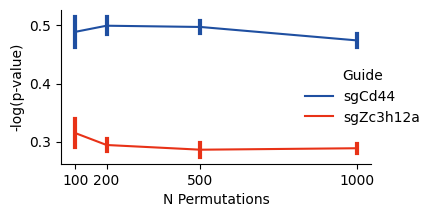

In [35]:
plot_df['-log10(p-value)'] = -np.log10(plot_df['value'])

plt.figure(figsize=(4, 2))
sns.lineplot(data=plot_df, x='index', y='-log10(p-value)', hue='variable', palette=['#1f4fa1', '#e83217'], errorbar='se', err_style='bars', err_kws={'linewidth': 3})
sns.despine()
plt.legend(title='Guide', loc='upper right', frameon=False, bbox_to_anchor=(1.2, 0.7))
plt.xticks([100, 200, 500, 1000], ['100', '200', '500', '1000'])
plt.xlabel('N Permutations')
plt.ylabel('-log(p-value)')
plt.rcParams['pdf.fonttype'] = 42
plt.savefig('../20240822-Pipeline/supplementary_images/permanova_perm_times.pdf', bbox_inches='tight', format='pdf')
plt.show()

In [ ]:
import warnings
from skbio.stats.distance import permanova, DistanceMatrix
from scipy.spatial.distance import pdist, squareform
from tqdm import tqdm
warnings.filterwarnings('ignore')

cd44_p_value = {}
zc3h12a_p_value = {}
for guide in tqdm(gdata.var_names):
    if guide != "sgCd44" and guide != "sgZc3h12a": continue
    for perm_metrics in ['euclidean', 'sqeuclidean', 'jensenshannon', 'braycurtis']:
        print(perm_metrics)
        g_df = c_df[[guide, "sgnon-targeting", "cluster"]]

        masks = {c: (g_df.cluster == c) for c in g_df.cluster.unique()}
        df = pd.DataFrame(columns=range(10))

        guide_cnts = np.array(pd.concat([df, g_df.groupby(['cluster', guide]).count().unstack()['sgnon-targeting']], axis=0).fillna(0))
        ntc_cnts = np.array(pd.concat([df, g_df.groupby(['cluster', 'sgnon-targeting']).count().unstack()[guide]], axis=0).fillna(0))
        data = np.vstack([guide_cnts, ntc_cnts])
        sample_ids = np.array([[name + str(c) for c in g_df.cluster.unique()] for name in ['guide_', 'control_']]).flatten()

        dist_matrix = squareform(pdist(data, metric=perm_metrics))
        metadata = pd.DataFrame({
            'group': ['A'] * 12 + ['B'] * 12
        }, index=sample_ids)
        dm = DistanceMatrix(dist_matrix, ids=sample_ids)

        results = permanova(dm, metadata, column='group', permutations=perm_times)
        #print(guide, results['p-value'])
        if guide == 'sgCd44':
            cd44_p_value[perm_metrics] = results['p-value']
        else:
            zc3h12a_p_value[perm_metrics] = results['p-value']

  9%|▉         | 3/34 [00:00<00:01, 21.14it/s]

euclidean


NameError: name 'perm_times' is not defined

In [143]:
pdf

,index,variable,value,-log10(p-value)
0,euclidean,sgCd44,0.674326,0.171130
1,sqeuclidean,sgCd44,0.498501,0.302334
2,jensenshannon,sgCd44,0.000999,3.000434
3,braycurtis,sgCd44,0.328671,0.483238
4,euclidean,sgZc3h12a,0.663337,0.178266
5,sqeuclidean,sgZc3h12a,0.500500,0.300596
6,jensenshannon,sgZc3h12a,0.000999,3.000434
7,braycurtis,sgZc3h12a,0.506494,0.295426


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


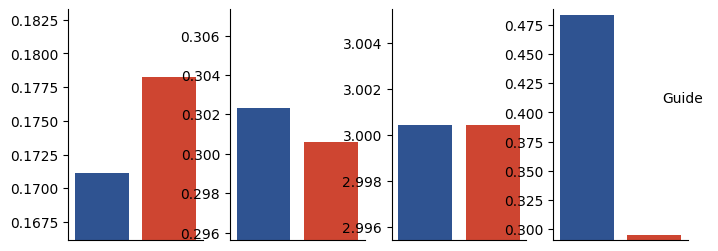

In [164]:
pdf = pd.DataFrame({
    'sgCd44': cd44_p_value.values(),
    'sgZc3h12a': zc3h12a_p_value.values()
}, index=cd44_p_value.keys()).melt(ignore_index=False).reset_index()
pdf['-log10(p-value)'] = -np.log10(pdf['value'])

# plt.figure(figsize=(4, 2))
_, ax = plt.subplots(1, 4, figsize=(8, 3))
for a, metric in zip(ax, ['euclidean', 'sqeuclidean', 'jensenshannon', 'braycurtis']):
    df = pdf[pdf['index'] == metric]
    sns.barplot(data=df, x='variable', y='-log10(p-value)', hue='variable', palette=['#1f4fa1', '#e83217'], ax=a,
                width=0.8, dodge=False)
    # a.set_title(metric)
    a.set_ylabel('')
    a.set_xlabel('')
    a.set_xticks([])
    a.set_ylim(df['-log10(p-value)'].min() - 0.005, df['-log10(p-value)'].max() + 0.005)
    # a.set_yticks([])
    if metric == 'braycurtis':
        a.legend(title='Guide', loc='upper right', frameon=False, bbox_to_anchor=(1.2, 0.7))
sns.despine()
# plt.xticks([100, 200, 500, 1000], ['100', '200', '500', '1000'])
plt.xlabel('')
plt.rcParams['pdf.fonttype'] = 42
plt.savefig('../20240822-Pipeline/supplementary_images/permanova_perm_metrics.pdf', bbox_inches='tight', format='pdf')
plt.show()

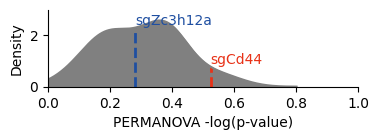

In [65]:
from statsmodels.nonparametric.kde import KDEUnivariate

# 初始化KDE估计器
perm_df = pd.DataFrame(p_value.values(), index=p_value.keys())
perm_df['-log10(p-value)'] = -np.log10(perm_df[0])
kde = KDEUnivariate(perm_df['-log10(p-value)'])

# 拟合数据
kde.fit()

# 绘制KDE曲线
plt.figure(figsize=(4, 1))
plt.xlim(0, 1)
plt.ylim(0, 3)

for gene, color in zip(['sgZc3h12a', 'sgCd44'], new_cmap(np.linspace(0, 1, 2))):
    if gene in perm_df.index:
        pos = perm_df.loc[gene, '-log10(p-value)']
        plt.vlines(x=pos, ymin=0, ymax=kde.density[np.abs(kde.support - pos).argmin()], color=color, linestyles='--',
                   alpha=1, linewidth=2)
        plt.text(pos, kde.density[np.abs(kde.support - pos).argmin()], gene, color=color, rotation=0, ha='left', va='bottom')

plt.fill_between(kde.support, kde.density, alpha=1, color='gray')
plt.plot(kde.support, kde.density, color='gray')

plt.xlabel('PERMANOVA -log(p-value)')
plt.ylabel('Density') 
sns.despine()

plt.rcParams['pdf.fonttype'] = 42
plt.savefig('../20240822-Pipeline/supplementary_images/permanova_kde.pdf',
            bbox_inches='tight', format='pdf')
plt.show()

In [30]:
gdata.obs['cluster'] = fdata.obs['cluster_cellcharter_givenk']

p_value = {}
for marker in ['2-1']:
    # mdata = gdata[gdata.obs.marker == marker]
    mdata = gdata

    c_df = pd.concat([pd.DataFrame(mdata.X, columns=mdata.var_names, index=mdata.obs_names), mdata.obs.cluster], axis=1)
    for guide in tqdm(mdata.var_names):
        if guide == "sgnon-targeting": continue
        g_df = c_df[[guide, "sgnon-targeting", "cluster"]]

        masks = {c: (g_df.cluster == c) for c in g_df.cluster.unique()}
        df = pd.DataFrame(columns=range(10))

        guide_cnts = np.array(pd.concat([df, g_df.groupby(['cluster', guide]).count().unstack()['sgnon-targeting']], axis=0).fillna(0))
        ntc_cnts = np.array(pd.concat([df, g_df.groupby(['cluster', 'sgnon-targeting']).count().unstack()[guide]], axis=0).fillna(0))
        data = np.vstack([guide_cnts, ntc_cnts])
        sample_ids = np.array([[name + str(c) for c in g_df.cluster.unique()] for name in ['guide_', 'control_']]).flatten()

        dist_matrix = squareform(pdist(data, metric='braycurtis'))
        metadata = pd.DataFrame({
            'group': ['A'] * 12 + ['B'] * 12
        }, index=sample_ids)
        dm = DistanceMatrix(dist_matrix, ids=sample_ids)

        results = permanova(dm, metadata, column='group', permutations=1000)
        p_value[guide] = results['test statistic']

    perm_df = pd.DataFrame(p_value.values(), index=p_value.keys())
    perm_df['F statistic'] = perm_df[0]
    perm_df.sort_values(by='F statistic', ascending=False, inplace=True)
    perm_df['perm_rank'] = np.arange(len(perm_df))
    perm_df.dropna(inplace=True)

  0%|          | 0/34 [00:00<?, ?it/s]

100%|██████████| 34/34 [04:14<00:00,  7.49s/it]


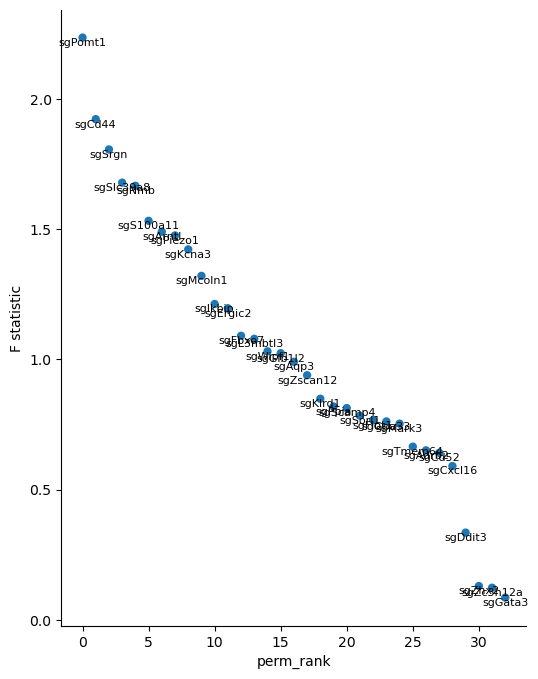

In [31]:
plt.figure(figsize=(6, 8))
sns.scatterplot(data=perm_df, x='perm_rank', y='F statistic', palette=['#1f4fa1', '#e83217'], legend=False, edgecolor='none')
for i, row in perm_df.iterrows():
    plt.text(row['perm_rank'], row['F statistic'], i, fontsize=8, alpha=1, ha='center', va='top', rotation=0)
sns.despine()
plt.show()

In [47]:
import warnings
from tqdm import tqdm
from skbio.stats.distance import permanova, DistanceMatrix
from scipy.spatial.distance import pdist, squareform
from scipy.stats import gaussian_kde
import random
warnings.filterwarnings('ignore')

N_PERMUTE = 1000

p_value = {}
p_value_permute = {}
for guide in tqdm(gdata.var_names):
    if guide == 'sgnon-targeting': continue
    g_df = c_df[[guide, "sgnon-targeting", "cluster"]]

    masks = {c: (g_df.cluster == c) for c in g_df.cluster.unique()}

    df = pd.DataFrame(index=range(12))
    g_df = c_df[[guide, "sgnon-targeting", "cluster"]]

    guide_df = g_df.groupby(['cluster', guide]).count().unstack()['sgnon-targeting']
    guide_cnts = df.copy()
    max_count = guide_df.columns.max()
    x_grid = np.linspace(0, max_count + 0.5, 10)
    
    guide_cnts = []
    for cluster in range(12):
        if cluster in guide_df.index:
            counts = guide_df.loc[cluster].dropna()
            kde = gaussian_kde(counts)
            density = kde(x_grid)
            density = density / density.sum()  # 归一化
            guide_cnts.append(density)
        else:
            guide_cnts.append(np.zeros_like(x_grid))
    guide_cnts = np.array(guide_cnts)

    ntc_df = g_df.groupby(['cluster', 'sgnon-targeting']).count().unstack()[guide]
    ntc_cnts = df.copy()
    max_count = ntc_df.columns.max()
    x_grid = np.linspace(0, max_count + 0.5, 10)
    
    ntc_cnts = []
    for cluster in range(12):
        if cluster in ntc_df.index:
            counts = ntc_df.loc[cluster].dropna()
            kde = gaussian_kde(counts)
            density = kde(x_grid)
            density = density / density.sum()  # 归一化
            ntc_cnts.append(density)
        else:
            ntc_cnts.append(np.zeros_like(x_grid))
            
    ntc_cnts = np.array(ntc_cnts)

    data = np.vstack([guide_cnts, ntc_cnts])
    sample_ids = np.array([[name + str(c) for c in g_df.cluster.unique()] for name in ['guide_', 'control_']]).flatten()

    dist_matrix = squareform(pdist(data, metric='braycurtis'))
    metadata = pd.DataFrame({
        'group': ['A'] * 12 + ['B'] * 12
    }, index=sample_ids)
    dm = DistanceMatrix(dist_matrix, ids=sample_ids)

    results = permanova(dm, metadata, column='group', permutations=1000)
    p_value[guide] = results['p-value']


    p_value_permute[guide] = []
    for i in range(N_PERMUTE):
        p_guide_cnts = guide_cnts.copy()
        p_ntc_cnts = ntc_cnts.copy()
        for j in range(12):
            if random.random() < 0.5:
                exchange_row = p_guide_cnts[j]
                p_guide_cnts[j] = p_ntc_cnts[j]
                p_ntc_cnts[j] = exchange_row

        p_data = np.vstack([p_guide_cnts, p_ntc_cnts])
        p_sample_ids = np.array([[name + str(c) for c in g_df.cluster.unique()] for name in ['guide_', 'control_']]).flatten()

        p_dist_matrix = squareform(pdist(p_data, metric='braycurtis'))
        p_metadata = pd.DataFrame({
            'group': ['A'] * 12 + ['B'] * 12
        }, index=p_sample_ids)
        p_dm = DistanceMatrix(p_dist_matrix, ids=p_sample_ids)
        p_results = permanova(p_dm, p_metadata, column='group', permutations=20)
        p_value_permute[guide].append(p_results['p-value'])

  0%|          | 0/34 [00:00<?, ?it/s]

100%|██████████| 34/34 [1:35:44<00:00, 168.97s/it]


In [99]:
permanova_p = pd.concat([pd.DataFrame(p_value_permute).T, perm_df[0]], axis=1)
permanova_p.columns = list(np.arange(1000)) + ['A']
# permanova_p.to_csv('./permanova_p_table.csv')
# for i in permanova_p.columns:
#     permanova_p.sort_values(by=i, inplace=True)
#     permanova_p[f'{i}_rank'] = np.arange(len(permanova_p))

In [112]:
from statsmodels.stats.multitest import fdrcorrection

permanova_p.columns = permanova_p.columns.astype(str)
# df = permanova_p.loc[:, permanova_p.columns.str.endswith('rank')].T + 1
# df = df.div(df.loc['A_rank'], axis=1)
# fdrcorrection((df <= 1).sum(axis=0) / 1000)
df = permanova_p.T
df = df.div(df.loc['A'], axis=1)
df = pd.concat([permanova_p['A'], (df > 1).sum(axis=0) / 1000], axis=1)
df.sort_values(by='A', inplace=True, ascending=False)
df.columns = ['F statistic', 'p-adjust']
df['p-adjust'] = fdrcorrection(df['p-adjust'])[1]
df['Rank'] = np.arange(len(df))
df.to_csv('./permanova_p_table.csv')

In [113]:
pd.concat([df, perm_df], axis=1)

,F statistic,p-adjust,Rank
sgPomt1,2.234801,0.000000,0
sgCd44,1.921665,0.000000,1
sgSrgn,1.805420,0.000000,2
sgSlc39a8,1.678000,0.000000,3
sgNmb,1.665954,0.000000,4
sgS100a11,1.531381,0.000000,5
sgArntl,1.489674,0.000000,6
sgPiezo1,1.475300,0.000000,7
sgKcna3,1.421848,0.000000,8
sgMcoln1,1.320145,0.000000,9


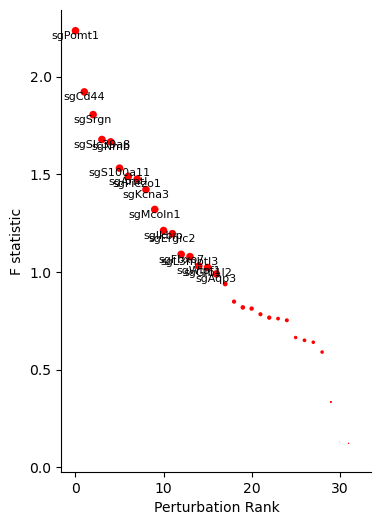

In [130]:
plt.figure(figsize=(4, 6))
sns.scatterplot(data=df, x='Rank', y='F statistic', s=-np.log10((df['p-adjust'] + 0.000001)) * 5,
                legend=False, edgecolor='none', color='red')
for i, row in df.iterrows():
    if row['p-adjust'] < 0.00001:
        plt.text(row['Rank'], row['F statistic'], i, fontsize=8, alpha=1, ha='center', va='top', rotation=0)
plt.xlabel('Perturbation Rank')
plt.ylabel('F statistic')
sns.despine()

plt.rcParams['pdf.fonttype'] = 42
plt.savefig('./permanova_rank.pdf', bbox_inches='tight', format='pdf')
plt.show()

In [48]:
permanova_p = pd.concat([pd.DataFrame(p_value_permute).T, perm_df[0]], axis=1).T
permanova_p = permanova_p.div(permanova_p.iloc[-1], axis=1)
(permanova_p > 1).sum()

sgAdrb2       28
sgAqp3         0
sgArntl        0
sgCd44         0
sgCd52        38
sgCxcl16      42
sgDdit3      298
sgErgic2       0
sgFbxo7        0
sgFlot1        7
sgGata3      999
sgGlb1l2       0
sgGpa33       25
sgIkbip        0
sgKcna3        0
sgKlrd1        9
sgL3mbtl3      0
sgMark3       16
sgMcoln1       0
sgNmb          0
sgPiezo1       0
sgPomt1        0
sgPpia         4
sgS100a11      0
sgScamp4       6
sgSlc39a8      0
sgSorl1       12
sgSrgn         0
sgTmem64      48
sgWipf1        0
sgZc3h12a    581
sgZhx2       872
sgZscan12      2
dtype: int64

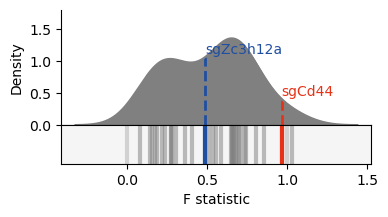

In [12]:
from statsmodels.nonparametric.kde import KDEUnivariate

# 初始化KDE估计器
# perm_df = pd.DataFrame(dist, index=g_df.index)
kde = KDEUnivariate(perm_df['F statistic'])

# 拟合数据
kde.fit()

# 绘制KDE曲线
fig, ax = plt.subplots(2, 1, figsize=(4, 2), sharex=False, height_ratios=[3, 1], gridspec_kw={'hspace': 0})
# ax[0].set_xlim(0, 7e-10)
ax[0].set_ylim(0, 1.8)

for gene, color in zip(['sgZc3h12a', 'sgCd44'], new_cmap(np.linspace(0, 1, 2))):
    if gene in perm_df.index:
        pos = perm_df.loc[gene, 'F statistic']
        ax[0].vlines(x=pos, ymin=0, ymax=kde.density[np.abs(kde.support - pos).argmin()], color=color, linestyles='--',
                   alpha=1, linewidth=2)
        ax[0].text(pos, kde.density[np.abs(kde.support - pos).argmin()], gene, color=color, rotation=0, ha='left', va='bottom')

ax[0].fill_between(kde.support, kde.density, alpha=1, color='gray')
ax[0].plot(kde.support, kde.density, color='gray')

lim = ax[0].get_xlim()

ax[0].set_xlabel('')
ax[0].set_xticks([])
ax[0].set_ylabel('Density')
sns.despine(ax=ax[0])

for row in perm_df.iterrows():
    # print(row)
    ax[1].vlines(x=row[1], ymin=0, ymax=1, color='gray', linestyles='-',
               alpha=0.3, linewidth=3)
for gene, color in zip(['sgZc3h12a', 'sgCd44'], new_cmap(np.linspace(0, 1, 2))):
    if gene in perm_df.index:
        pos = perm_df.loc[gene, 'F statistic']
        ax[1].vlines(x=pos, ymin=0, ymax=1, color=color, linestyles='-',
                   alpha=1, linewidth=3)

ax[1].set_facecolor('whitesmoke')
ax[1].set_ylim(0, 1)
ax[1].set_xlim(lim)
ax[1].set_xlabel('F statistic')
ax[1].set_ylabel('')
ax[1].set_yticks([])

# plt.rcParams['pdf.fonttype'] = 42
# plt.savefig('../20240822-Pipeline/supplementary_images/permanova_kde.pdf',
            # bbox_inches='tight', format='pdf')
plt.show()

In [27]:
from scipy.stats import pearsonr

pearson_r = {}
gdata.obs['cluster'] = fdata.obs['cluster_cellcharter_givenk']

for marker in ['2-1', '2-2', '1-1', '1-2', '3-1', '3-2']:
    mdata = gdata[gdata.obs.marker == marker]
    c_df = pd.concat([pd.DataFrame(mdata.X, columns=mdata.var_names, index=mdata.obs_names), mdata.obs["cluster"]], axis=1)
    c_df = c_df.groupby('cluster').sum()
    c_df = c_df.div(c_df.sum(axis=0)) * c_df.loc[:, 'sgnon-targeting'].sum()

    g_df = c_df.unstack().unstack().apply(lambda x: 10 ** (np.log10(x + 1) - (np.log10(x + 1).sum() / 12)), axis=1)
    g_df.fillna(0, inplace=True)
    dist = g_df.apply(lambda x: euclidean(x, g_df.loc['sgnon-targeting']), axis=1).values

    chi_df = pd.DataFrame(dist, index=g_df.index)
    chi_df.sort_values(by=0, ascending=True, inplace=True)
    # chi_df['chi_p'] = -np.log10(chi_df[0])
    chi_df.dropna(inplace=True)
    chi_df['chi_rank'] = np.arange(len(chi_df))

    p_value = {}
    c_df = pd.concat([pd.DataFrame(mdata.X, columns=mdata.var_names, index=mdata.obs_names), mdata.obs.cluster], axis=1)
    for guide in tqdm(mdata.var_names):
        if guide == "sgnon-targeting": continue
        g_df = c_df[[guide, "sgnon-targeting", "cluster"]]

        masks = {c: (g_df.cluster == c) for c in g_df.cluster.unique()}
        df = pd.DataFrame(columns=range(10))

        guide_cnts = np.array(pd.concat([df, g_df.groupby(['cluster', guide]).count().unstack()['sgnon-targeting']], axis=0).fillna(0))
        ntc_cnts = np.array(pd.concat([df, g_df.groupby(['cluster', 'sgnon-targeting']).count().unstack()[guide]], axis=0).fillna(0))
        data = np.vstack([guide_cnts, ntc_cnts])
        sample_ids = np.array([[name + str(c) for c in g_df.cluster.unique()] for name in ['guide_', 'control_']]).flatten()

        dist_matrix = squareform(pdist(data, metric='braycurtis'))
        metadata = pd.DataFrame({
            'group': ['A'] * 12 + ['B'] * 12
        }, index=sample_ids)
        dm = DistanceMatrix(dist_matrix, ids=sample_ids)

        results = permanova(dm, metadata, column='group', permutations=200)
        p_value[guide] = results['p-value']

    perm_df = pd.DataFrame(p_value.values(), index=p_value.keys())
    perm_df['-log10(p-value)'] = -np.log10(perm_df[0])
    perm_df.sort_values(by='-log10(p-value)', ascending=False, inplace=True)
    perm_df['perm_rank'] = np.arange(len(perm_df))
    perm_df.dropna(inplace=True)

    merge_df = pd.concat([perm_df, chi_df], axis=1).sort_values(by='-log10(p-value)', ascending=False)
    merge_df['perm_rank'] = np.arange(len(merge_df))
    merge_df.dropna(inplace=True)

    pearson_r[marker] = pearsonr(merge_df['perm_rank'], merge_df['chi_rank'])[0]


100%|██████████| 34/34 [00:35<00:00,  1.04s/it]


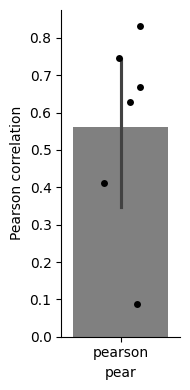

In [31]:
# 将pearson_r转换为DataFrame以便绘图
pearson_df = pd.DataFrame({'correlation': pearson_r.values()})
pearson_df['correlation'] = pearson_df['correlation'].abs()
pearson_df['pear'] = 'pearson'

plt.figure(figsize=(2, 4))
sns.barplot(pearson_df, x='pear', y='correlation', color='gray', width=0.8)
# 添加swarm散点图
sns.stripplot(data=pearson_df, y='correlation', x='pear', color='black', jitter=0.2)

plt.ylabel("Pearson correlation")
# plt.title("Correlation between permutation\nand chi-square ranks")
sns.despine()
plt.tight_layout()

plt.rcParams['pdf.fonttype'] = 42
plt.savefig('../20240822-Pipeline/supplementary_images/permanova_chi2_correlation.pdf',
            bbox_inches='tight', format='pdf')
plt.show()
